In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
import tools
from analysis_tools import check_data

from tools.FV3_tools import read_solo_fields
from tools.WRF_tools import read_wrf_fields
from tools.CM1_tools import read_cm1_fields

import pickle
from tools.cbook import pickle2Obj

_nthreads = 2

edges = np.array([0, 0.01, 0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 6.0, 8.0, 10.0, 12.0])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
wrf_dir  = '/work/wicker/climate_runs/WRF/WRF_v4.4.2/ideal'
cm1_dir  = '/work/wicker/climate_runs/cm1r20.3/run/'
mpas_dir = '/work/wicker/climate_runs/MPAS/squall/base'
wpas_dir = '/work/wicker/climate_runs/MPAS/squall/wofs'

models = {}



In [3]:
models['wrf']      = pickle2Obj(os.path.join(wrf_dir, 'base/precip.pkl'),retObj=False)



In [4]:
models['cm1']      = pickle2Obj(os.path.join(cm1_dir, 'base/precip.pkl'),retObj=False)

In [5]:
models['mpas']    = pickle2Obj(os.path.join(mpas_dir, 'precip.pkl'),retObj=False)

In [13]:
models['wpas']    = pickle2Obj(os.path.join(wpas_dir, 'precip.pkl'),retObj=False)

In [14]:
models1 = {}
models1['mpas']     = models['mpas']
models1['mpas-wof'] = models['wpas']
models1['wrf-5']    = models['wrf']    
models1['cm1-5']    = models['cm1'] 

In [47]:
from scipy.stats import gaussian_kde

from sklearn.neighbors import KernelDensity

def precip_histogram(models, label, all_times=False, KDE=False):
    
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(7,7))
    
    if all_times:
        xlim = [0.01, 200.]
            
    else:
        xlim = [0.01, 75.]
    
    for key in models.keys():
        
        if all_times:
            
            precip_dt = models[key][label]['accum_prec']
            
        else:
    
        # first, compute the increments in time of precip
    
            inv = models[key][label]['accum_prec'][::-1]
    
            precip_dt = inv[0:-1] - inv[1:]

            for n in np.arange(6):
                m = n * 4
                precip_hour = precip_dt[m] + precip_dt[m+1] +precip_dt[m+2] +precip_dt[m+3]

            precip_dt = precip_hour
        
        # get rid of zeros...
    
        data_flat =precip_dt.flatten()
        
        data_no_zero = data_flat[data_flat >= 1.0e-1]

        if KDE:
        
            hist, bin_edges = np.histogram(data_no_zero)
    
            eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges))
            kde_sp      = gaussian_kde(data_no_zero, bw_method=0.7)
            y_sp        = kde_sp.pdf(eval_points)
            
            if key == 'solo':
                ax.plot(eval_points, y_sp, color='r', linewidth=2.0, label='SOLO (%d)' % data_no_zero.shape)
                
            if key == 'solo_hdd012':
                ax.plot(eval_points, y_sp, color='darkred', linewidth=2.0, linestyle=':', label='SOLO-D012 (%d)' % data_no_zero.shape)
            
            if key == 'solo_hdd125':
                ax.plot(eval_points, y_sp, color='red', linewidth=2.0, linestyle='solid', label='SOLO-D125 (%d)' % data_no_zero.shape)
    
            if key == 'wrf-5':
                ax.plot(eval_points, y_sp, color='k', linewidth=2.0, label='WRF (%d)' % data_no_zero.shape)
            
            if key == 'wrf-4':
                ax.plot(eval_points, y_sp, color='k', linewidth=1.0, label='WRF (%d)' % data_no_zero.shape)
                
            if key == 'cm1-5':
                ax.plot(eval_points, y_sp, color='b', linewidth=2.0, label='CM1 (%d)' % data_no_zero.shape)
    
            if key == 'cm1-4':
                ax.plot(eval_points, y_sp, color='b', linewidth=1.0, label='CM1 (%d)' % data_no_zero.shape)
    
            if key == 'mpas':
                ax.plot(eval_points, y_sp, color='r', linewidth=2.0, label='MPAS (%d)' % data_no_zero.shape)
    
            if key == 'mpas-wof':
                ax.plot(eval_points, y_sp, color='g', linewidth=1.0, linestyle='--', label='MPAS-WOF (%d)' % data_no_zero.shape)
     
            ax.set_xlim(xlim[:])
            ax.set_yscale("log")
        #    ax.set_xscale("log", base=2.0)
            plt.grid(axis='y', alpha=0.75)
            plt.grid(axis='x', alpha=0.75)
            ax.set_xlabel('mm',fontsize=15)
            ax.set_ylabel('Density',fontsize=15)
            legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
            if all_times:
                ax.axvline(x=100.0, color='k', linestyle='--', linewidth=2.0)
                ax.axvline(x=150.0, color='k', linestyle='--', linewidth=2.0)
                ax.set_title('Accum Precipitation for EXP:  %s' % (label), fontsize=15)
                plt.savefig("Total_Accumulated_Precipitation_KDE_Experiment_%s.png" % (label))
            else:
                ax.axvline(x=40.0, color='k', linestyle='--', linewidth=2.0)
                ax.axvline(x=20.0, color='k', linestyle='--', linewidth=2.0)
                ax.set_title('Hourly Accumulated Precipitation KDE for EXP:  %s' % (label), fontsize=15)
                plt.savefig("Hourly Accumulated_Precipitation_KDE_Experiment_%s.png" % (label))

        else:

            print(data_no_zero.max(), data_no_zero.min())

            kde = KernelDensity(kernel='gaussian', bandwidth=0.9).fit(data_no_zero[:, np.newaxis])
            x_range = np.linspace(0.0, 100, num=600)
            print(x_range.min(), x_range.max())
            log_density = kde.score_samples(x_range[:, np.newaxis])

            if key == 'cm1-5':
                ax.plot(x_range, np.exp(log_density), color='b', linewidth=2.0, label='CM1 (%d)' % data_no_zero.shape)

            if key == 'wrf-5':
                ax.plot(x_range, np.exp(log_density), color='k', linewidth=2.0, label='WRF (%d)' % data_no_zero.shape)

            if key == 'mpas':
                ax.plot(x_range, np.exp(log_density), color='r', linewidth=2.0, label='MPAS (%d)' % data_no_zero.shape)
    
            if key == 'mpas-wof':
                ax.plot(x_range, np.exp(log_density), color='r', linewidth=1.0, linestyle='--', label='MPAS-WOFS (%d)' % data_no_zero.shape)
    
            ax.set_xlim([0.01, 100])
            ax.set_yscale("log")
            plt.grid(axis='y', alpha=0.75)
            plt.grid(axis='x', alpha=0.75)
            ax.set_xlabel('inches',fontsize=15)
      #      legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

            if all_times:
                ax.axvline(x=100.0, color='k', linestyle='--', linewidth=2.0)
                ax.axvline(x=150.0, color='k', linestyle='--', linewidth=2.0)
                ax.set_title('Accum Precipitation for EXP:  %s' % (label), fontsize=15)
                plt.savefig("Total_Accumulated_Precipitation_KDE_Experiment_%s.png" % (label))
            else:
                ax.axvline(x=40.0, color='k', linestyle='--', linewidth=2.0)
                ax.axvline(x=20.0, color='k', linestyle='--', linewidth=2.0)
                ax.set_title('Hourly Accumlated Precipitation KDE for EXP:  %s' % (label), fontsize=15)
                plt.savefig("Hourly Accumulated_Precipitation_KDE_Experiment_%s.png" % (label))

    plt.show()
    


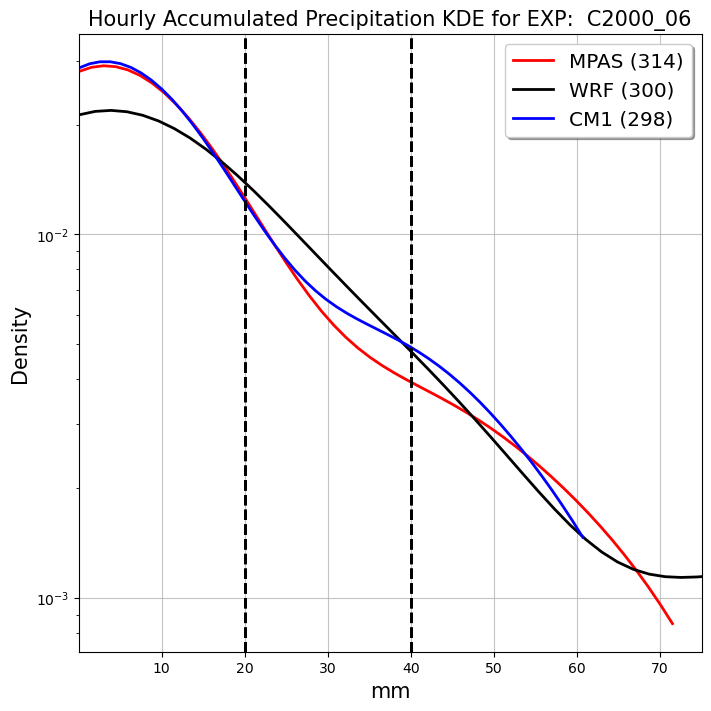

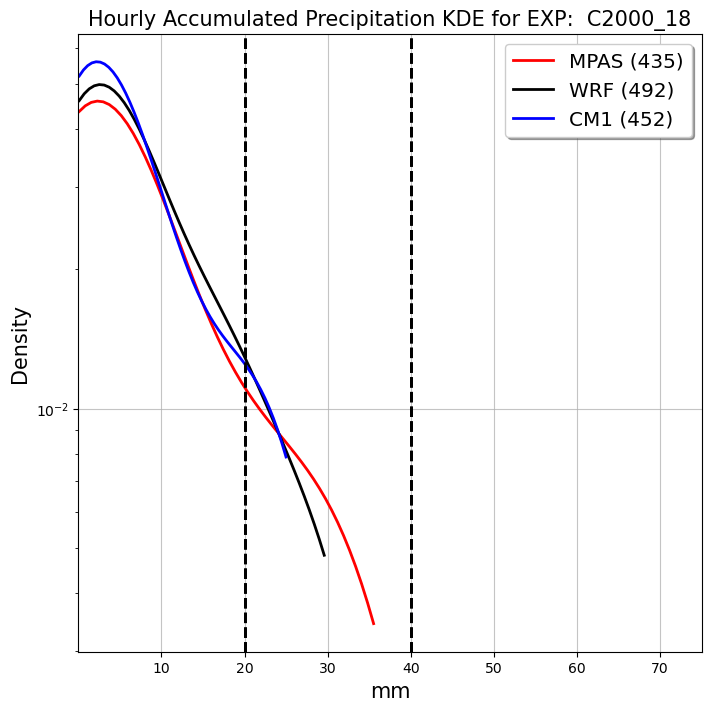

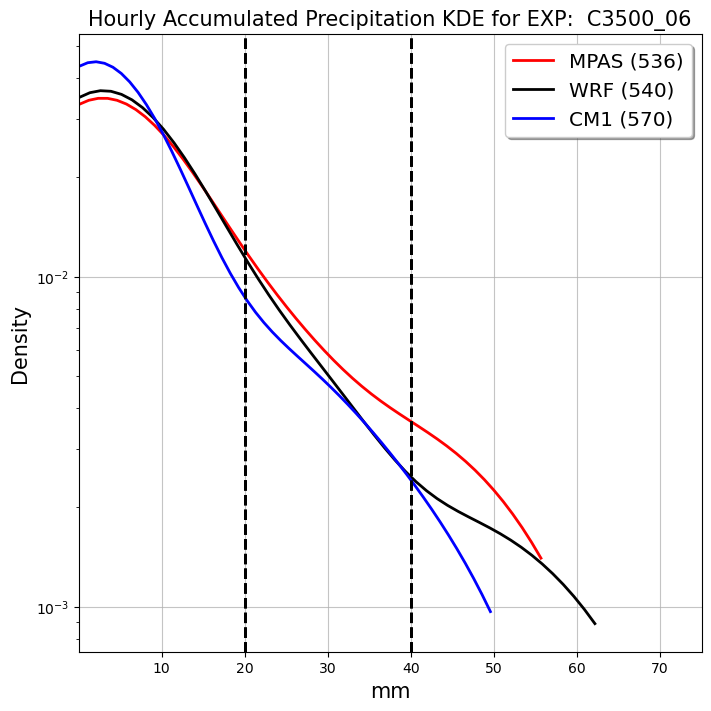

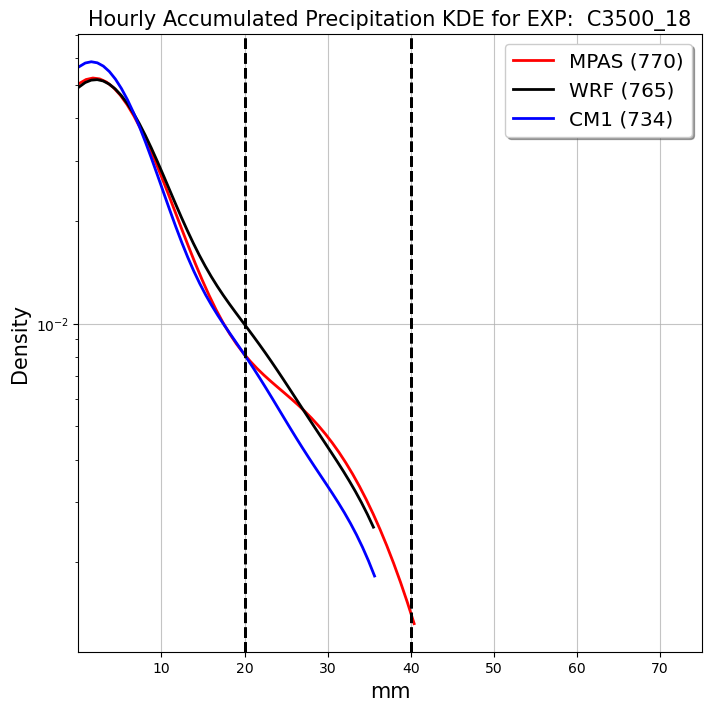

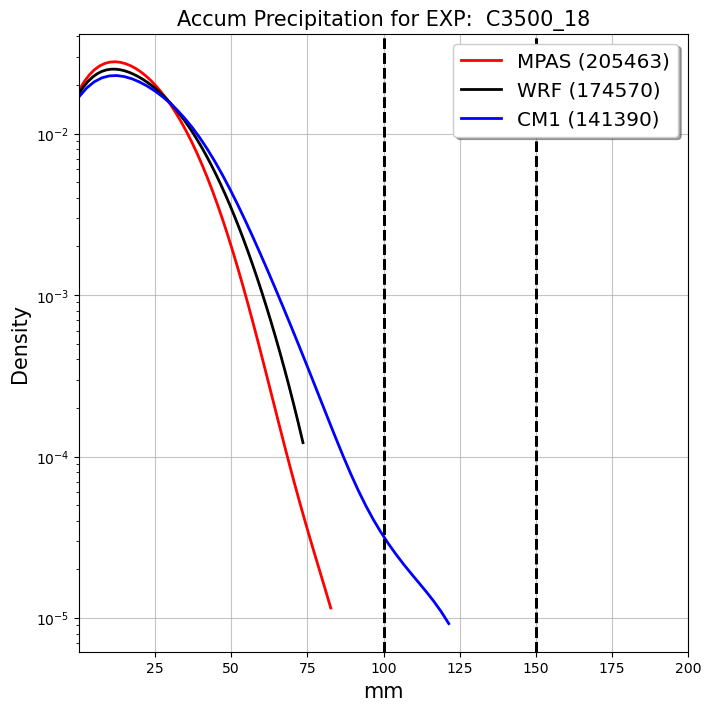

In [48]:

#precip_histogram(models1, 'C2000_06', all_times = True, KDE=True)
precip_histogram(models1, 'C2000_06', all_times = False, KDE=True)
#precip_histogram(models1, 'C2000_18', all_times = True, KDE=True)
precip_histogram(models1, 'C2000_18', all_times = False, KDE=True)

precip_histogram(models1, 'C3500_06', KDE=True)
#precip_histogram(models1, 'C3500_06', all_times = True, KDE=True)
precip_histogram(models1, 'C3500_18', KDE=True)
#
precip_histogram(models1, 'C3500_18', all_times = True, KDE=True)

# precip_histogram(models1, 'C2000_06', KDE=False)
# precip_histogram(models1, 'C2000_18', KDE=False)
# precip_histogram(models1, 'C3500_06', KDE=False)
# precip_histogram(models1, 'C3500_18', KDE=False)

# precip_histogram(models3, 'C2000_06')
# precip_histogram(models3, 'C3500_06')
# precip_histogram(models3, 'C3500_18')
# 

# precip_histogram(models, 'C2000_06', all_times = True)
# precip_histogram(models, 'C3500_06', all_times = True)
# precip_histogram(models, 'C2500_06')
# precip_histogram(models, 'C3000_06')

#precip_histogram(models, 'C2000_12')
#precip_histogram(models, 'C2000_06', all_times = True)
#precip_histogram(models, 'C2000_18')
#precip_histogram(models, 'C2000_12')
#precip_histogram(models, 'C2000_18')

#precip_histogram(models, 'C2000_12')


#precip_histogram(models, 'C2000_12')
# precip_histogram(models, 'C3500_18', all_times = True)

In [16]:
from scipy.stats import gaussian_kde

from sklearn.neighbors import KernelDensity

def precip_histogramAGG(models):
    
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(7,7))
    
    xlim = [0.01, 75.]

    labels =   ['C2000_06',
                'C2500_06',
                'C3000_06',
                'C3500_06',
                'C2000_12',
                'C2500_12',
                'C3000_12',
                'C3500_12',
                'C2000_18',
                'C2500_18',
                'C3000_18',
                'C3500_18']
    
    for key in models.keys():
            
    # first, compute hourly precip

        index = 0

        for label in labels:
                
            inv = models[key][label]['accum_prec'][::-1]

            precip = inv[0:-1] - inv[1:]

            for n in np.arange(6):
                m = n * 4
                precip_hour = precip[m] + precip[m+1] +precip[m+2] +precip[m+3]

            if index == 0:
                precip_dt = precip_hour.flatten()
            else:
                precip_dt = np.append(precip_dt, precip_hour.flatten())
                
            index += 1
    
        # get rid of zeros...
    
        data_flat = precip_dt.flatten()
        
        data_no_zero = data_flat[data_flat >= 1.0e-1]

        print(data_no_zero.shape)

        
        hist, bin_edges = np.histogram(data_no_zero)

        eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges))
        kde_sp      = gaussian_kde(data_no_zero, bw_method=0.5)
        y_sp        = kde_sp.pdf(eval_points)
        
        if key == 'solo':
            ax.plot(eval_points, y_sp, color='r', linewidth=2.0, label='SOLO (%d)' % data_no_zero.shape)
            
        if key == 'solo_hdd012':
            ax.plot(eval_points, y_sp, color='darkred', linewidth=2.0, linestyle=':', label='SOLO-D012 (%d)' % data_no_zero.shape)
        
        if key == 'solo_hdd125':
            ax.plot(eval_points, y_sp, color='red', linewidth=2.0, linestyle='solid', label='SOLO-D125 (%d)' % data_no_zero.shape)

        if key == 'wrf-5':
            ax.plot(eval_points, y_sp, color='k', linewidth=2.0, label='WRF (%d)' % data_no_zero.shape)
        
        if key == 'wrf-4':
            ax.plot(eval_points, y_sp, color='k', linewidth=1.0, label='WRF (%d)' % data_no_zero.shape)
            
        if key == 'cm1-5':
            ax.plot(eval_points, y_sp, color='b', linewidth=2.0, label='CM1 (%d)' % data_no_zero.shape)

        if key == 'cm1-4':
            ax.plot(eval_points, y_sp, color='b', linewidth=1.0, label='CM1 (%d)' % data_no_zero.shape)

        if key == 'mpas':
            ax.plot(eval_points, y_sp, color='r', linewidth=2.0, label='MPAS (%d)' % data_no_zero.shape)

        if key == 'mpas-wof':
            ax.plot(eval_points, y_sp, color='g', linewidth=2.0, label='MPAS-WOF (%d)' % data_no_zero.shape)
 
        ax.set_xlim(xlim[:])
        ax.set_yscale("log")
    #    ax.set_xscale("log", base=2.0)
        plt.grid(axis='y', alpha=0.75)
        plt.grid(axis='x', alpha=0.75)
        ax.set_xlabel('mm',fontsize=15)
        ax.set_ylabel('Density',fontsize=15)
        legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
        ax.axvline(x=40.0, color='k', linestyle='--', linewidth=2.0)
        ax.axvline(x=20.0, color='k', linestyle='--', linewidth=2.0)
        ax.set_title('KDE of Hourly Accumulated Precipitation All Experiments', fontsize=15)
        plt.savefig("KDE_Hourly_Accumulated_Precipitation_KDE_Experiment_%s.png" % ('ALL'))

    plt.show()
    


(6133,)
(5420,)
(6233,)
(6014,)


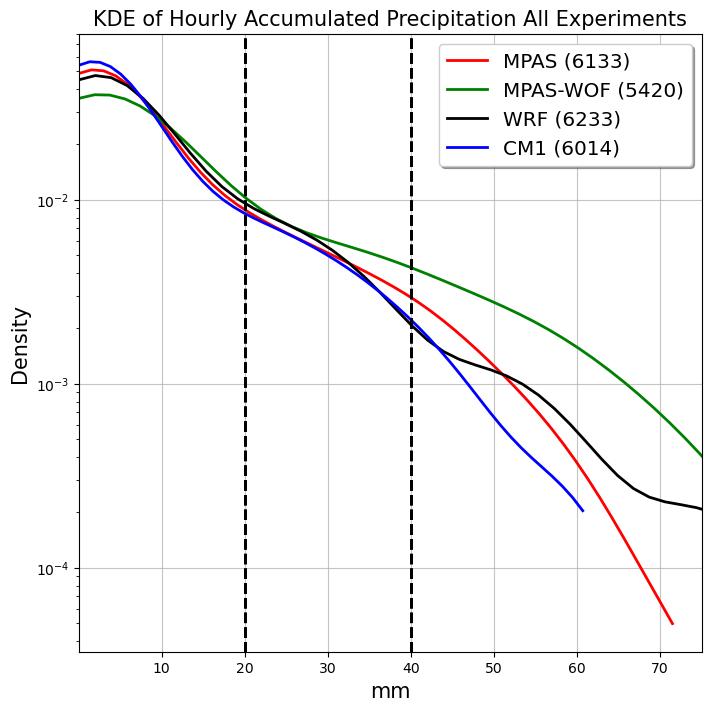

In [17]:
precip_histogramAGG(models1)